In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import resource
import time
from datetime import datetime
import math
import os
from sklearn import preprocessing
import sys
import cvxpy
from multiprocessing import Process, Pipe
from multiprocessing.pool import ThreadPool

## NOTE: Install keras --------------------------------------------------------------------
###------------------- keras imports for the dataset and neural network --------------------##
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras import optimizers
from keras.layers.normalization import BatchNormalization

%matplotlib inline


Using TensorFlow backend.


In [2]:
image_size = 28
num_features = image_size * image_size
num_classes = 10

num_train = 49000

## Load MNIST Dataset

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('Train data shape: {}'.format(X_train.shape))
print('Test  data shape: {}'.format(X_test.shape))

Train data shape: (60000, 28, 28)
Test  data shape: (10000, 28, 28)


## Data Visualization

In [4]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
samples_per_class = 5

plt.figure(figsize=(16, 8))

for cls, name in enumerate(class_names):
    idxs = np.flatnonzero(y_train == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(samples_per_class, num_classes, i * num_classes + cls + 1)
        plt.imshow(X_train[idx], interpolation='spline16')
        plt.axis('off')
        if i == 0:
            plt.title(class_names[cls])

## Data Preprocessing

In [5]:
# Convert 3D arrays to 2D arrays
X_train =  X_train.reshape([-1, num_features])
X_test  =  X_test.reshape([-1, num_features])

print('Train data shape: {}'.format(X_train.shape))
print('Test  data shape: {}'.format(X_test.shape))

Train data shape: (60000, 784)
Test  data shape: (10000, 784)


In [6]:
# convert pixel range from [0, 255] to [0., 1.]
X_train = X_train.astype('float32')
x_test  = X_test.astype('float32')

mu = np.mean(X_train, axis=0)

X_train -= mu
X_train /= 255.0

x_test -= mu
x_test /= 255.0

## One-hot encodding
- We have 10 classes: 0, 1, ..., 9

In one-hot encoding, we represent labels using vectors.

```python
0: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
.
.
.
9: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
```

In [7]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


# Multi-layer Neural Network

### $$f(x) = W_3 \times f(W_2 \times f(0, W_1 x))$$

In [8]:
model = Sequential()

# First hidden Layer
model.add(Dense(units=100, input_shape=(num_features,)))
model.add(Activation(activation='relu'))

# Second hidden Layer
model.add(Dense(units=100))
model.add(Activation(activation='relu'))

# hird Layer
model.add(Dense(units=100, input_shape=(num_features,)))
model.add(Activation(activation='relu'))


# Output Layer
model.add(Dense(units=num_classes, activation='softmax'))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [10]:
model.save_weights('model.h5')

### Training the model

In Keras batch_size refers to the batch size in Mini_batch Gradient Descent. It means that if we want to run batch gradient descent, we can set the batch_size to the number of training sample.

### Batch size = 128,  With constant Learning rate (lr=0.01)

In [11]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
start = time.time()
history = model.fit(X_train[:num_train], y_train[:num_train], 
                    batch_size=128, 
                    epochs=30,
                    verbose=2,
                    validation_data=(X_train[num_train:], y_train[num_train:]),
                    shuffle=True)
end = time.time()
print("Time duration for constant learning rate:",end-start)

Train on 49000 samples, validate on 11000 samples
Epoch 1/30
 - 1s - loss: 1.9321 - accuracy: 0.4286 - val_loss: 1.3908 - val_accuracy: 0.6491
Epoch 2/30
 - 1s - loss: 0.9536 - accuracy: 0.7683 - val_loss: 0.5888 - val_accuracy: 0.8563
Epoch 3/30
 - 1s - loss: 0.4988 - accuracy: 0.8671 - val_loss: 0.3870 - val_accuracy: 0.8949
Epoch 4/30
 - 1s - loss: 0.3696 - accuracy: 0.8963 - val_loss: 0.3140 - val_accuracy: 0.9109
Epoch 5/30
 - 2s - loss: 0.3114 - accuracy: 0.9102 - val_loss: 0.2755 - val_accuracy: 0.9214
Epoch 6/30
 - 1s - loss: 0.2761 - accuracy: 0.9190 - val_loss: 0.2504 - val_accuracy: 0.9268
Epoch 7/30
 - 2s - loss: 0.2511 - accuracy: 0.9265 - val_loss: 0.2311 - val_accuracy: 0.9342
Epoch 8/30
 - 1s - loss: 0.2316 - accuracy: 0.9320 - val_loss: 0.2159 - val_accuracy: 0.9382
Epoch 9/30
 - 1s - loss: 0.2155 - accuracy: 0.9366 - val_loss: 0.2041 - val_accuracy: 0.9414
Epoch 10/30
 - 2s - loss: 0.2020 - accuracy: 0.9393 - val_loss: 0.1931 - val_accuracy: 0.9445
Epoch 11/30
 - 2s -

In [13]:
model.save('Multi_layer_NN_Model_Constatnt.CA7')
#model = keras.models.load_model('Multi_layer_NN_Model_Constatnt.CA7')

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs Validation Loss for Constant learning rate")
plt.show()

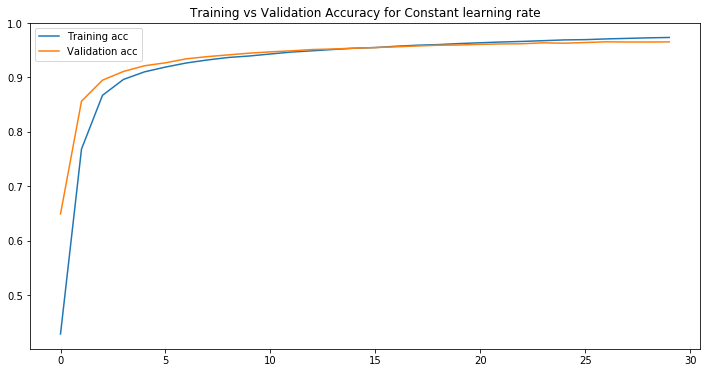

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.legend()
plt.title("Training vs Validation Accuracy for Constant learning rate")
plt.show()

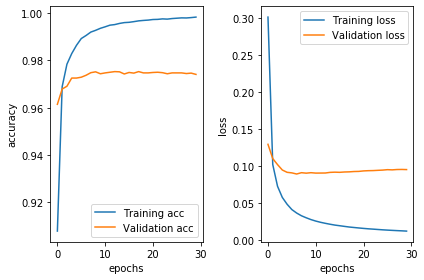

In [45]:
f, axs = plt.subplots(1,2)
axs[0].plot(history.history['accuracy'], label="Training acc")
axs[0].plot(history.history['val_accuracy'], label="Validation acc")
axs[0].legend()
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
#axs[0].set_ylim([0.96, 1])
axs[1].plot(history.history['loss'], label="Training loss")
axs[1].plot(history.history['val_loss'], label="Validation loss")
axs[1].legend()
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
#axs[1].set_ylim([0, 0.35])
plt.tight_layout()

In [26]:
# Select 25 random images from test images
idx = np.random.choice(X_test.shape[0], 25, replace=False)

# predict class for selected images
y_pred = model.predict_classes(X_test[idx])

# True class for selected images
y_true = y_test[idx].argmax(axis=1)

print('Test Accuracy of Model with Constant learning rate = %.2f' % (100.0 * np.mean(y_pred == y_true)))

Test Accuracy of Model with Constant learning rate = 88.00


Multi_layer_NN with Constant Learning Rate


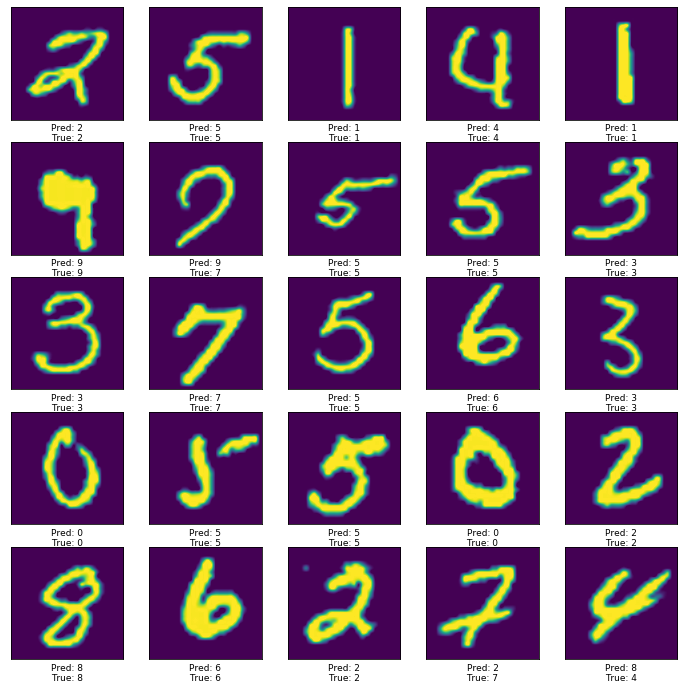

In [27]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
print("Multi_layer_NN with Constant Learning Rate")
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[idx[i]].reshape(image_size, image_size), interpolation='spline16')
    pred_class = class_names[y_pred[i]]
    true_class = class_names[y_true[i]]
    ax.set_xlabel('Pred: {}\nTrue: {}'.format(pred_class, true_class), fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

### Batch size = 128,  Use diminishing learning rate

In [28]:
model.load_weights('model.h5')
lr = 0.1
epochs = 30
decay_rate = lr / epochs
momentum = 0.8

In [29]:
optimizer = keras.optimizers.SGD(lr=lr, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
start = time.time()
history = model.fit(X_train[:num_train], y_train[:num_train], 
                    batch_size=128, 
                    epochs=30,
                    verbose=2,
                    validation_data=(X_train[num_train:], y_train[num_train:]),
                    shuffle=True)
end = time.time()
print("Time duration for diminishing learning rate:",end-start)

Train on 49000 samples, validate on 11000 samples
Epoch 1/30
 - 2s - loss: 0.3009 - accuracy: 0.9079 - val_loss: 0.1290 - val_accuracy: 0.9615
Epoch 2/30
 - 2s - loss: 0.1017 - accuracy: 0.9689 - val_loss: 0.1097 - val_accuracy: 0.9679
Epoch 3/30
 - 2s - loss: 0.0723 - accuracy: 0.9784 - val_loss: 0.1016 - val_accuracy: 0.9691
Epoch 4/30
 - 2s - loss: 0.0572 - accuracy: 0.9829 - val_loss: 0.0943 - val_accuracy: 0.9725
Epoch 5/30
 - 2s - loss: 0.0480 - accuracy: 0.9864 - val_loss: 0.0912 - val_accuracy: 0.9725
Epoch 6/30
 - 2s - loss: 0.0408 - accuracy: 0.9892 - val_loss: 0.0904 - val_accuracy: 0.9729
Epoch 7/30
 - 2s - loss: 0.0361 - accuracy: 0.9905 - val_loss: 0.0889 - val_accuracy: 0.9737
Epoch 8/30
 - 2s - loss: 0.0325 - accuracy: 0.9920 - val_loss: 0.0907 - val_accuracy: 0.9748
Epoch 9/30
 - 2s - loss: 0.0297 - accuracy: 0.9927 - val_loss: 0.0900 - val_accuracy: 0.9752
Epoch 10/30
 - 2s - loss: 0.0273 - accuracy: 0.9936 - val_loss: 0.0907 - val_accuracy: 0.9744
Epoch 11/30
 - 2s -

In [31]:
#model.save('Multi_layer_NN_Model_Diminishing.CA7')
#model = keras.models.load_model('Multi_layer_NN_Model_Diminishing.CA7')

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs Validation Loss for diminishing learning rate")
plt.show()

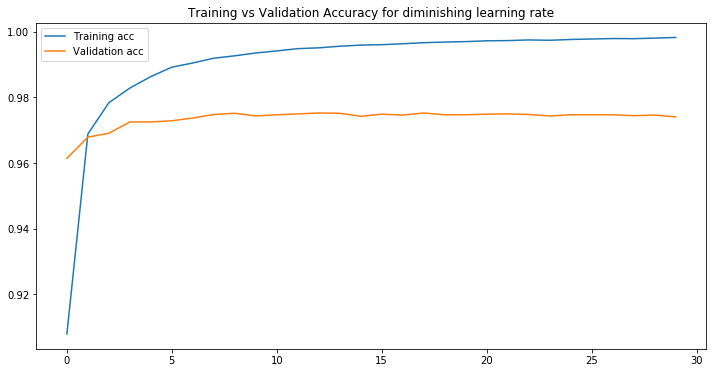

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.legend()
plt.title("Training vs Validation Accuracy for diminishing learning rate")
plt.show()

In [44]:
f, axs = plt.subplots(1,2)
axs[0].plot(history.history['accuracy'], label="Training acc")
axs[0].plot(history.history['val_accuracy'], label="Validation acc")
axs[0].legend()
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[0].set_ylim([0.85, 1])
axs[1].plot(history.history['loss'], label="Training loss")
axs[1].plot(history.history['val_loss'], label="Validation loss")
axs[1].legend()
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
axs[1].set_ylim([0, 0.35])
plt.tight_layout()

In [46]:
# Select 25 random images from test images
idx = np.random.choice(X_test.shape[0], 25, replace=False)

# predict class for selected images
y_pred = model.predict_classes(X_test[idx])

# True class for selected images
y_true = y_test[idx].argmax(axis=1)

print('Test Accuracy of diminishing learning rate = %.2f' % (100.0 * np.mean(y_pred == y_true)))

Test Accuracy of diminishing learning rate = 92.00


In [47]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
print("Multi_layer_NN with Diminishing Learning Rate")
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[idx[i]].reshape(image_size, image_size), interpolation='spline16')
    pred_class = class_names[y_pred[i]]
    true_class = class_names[y_true[i]]
    ax.set_xlabel('Pred: {}\nTrue: {}'.format(pred_class, true_class), fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

Multi_layer_NN with Diminishing Learning Rate


### Batch size = 128,  Use AdaGrad Optimizer

In [48]:
model.load_weights('model.h5')
optimizer = keras.optimizers.Adagrad()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
start = time.time()
history = model.fit(X_train[:num_train], y_train[:num_train], 
                    batch_size=128, 
                    epochs=30,
                    verbose=2,
                    validation_data=(X_train[num_train:], y_train[num_train:]),
                    shuffle=True)
end = time.time()
print("Time duration for AdaGrad Optimizer:",end-start)

Train on 49000 samples, validate on 11000 samples
Epoch 1/30
 - 1s - loss: 0.2230 - accuracy: 0.9304 - val_loss: 0.1359 - val_accuracy: 0.9600
Epoch 2/30
 - 1s - loss: 0.1055 - accuracy: 0.9681 - val_loss: 0.1109 - val_accuracy: 0.9667
Epoch 3/30
 - 1s - loss: 0.0781 - accuracy: 0.9771 - val_loss: 0.1034 - val_accuracy: 0.9688
Epoch 4/30
 - 1s - loss: 0.0626 - accuracy: 0.9816 - val_loss: 0.0952 - val_accuracy: 0.9718
Epoch 5/30
 - 1s - loss: 0.0512 - accuracy: 0.9850 - val_loss: 0.0912 - val_accuracy: 0.9726
Epoch 6/30
 - 1s - loss: 0.0436 - accuracy: 0.9878 - val_loss: 0.0906 - val_accuracy: 0.9742
Epoch 7/30
 - 1s - loss: 0.0367 - accuracy: 0.9902 - val_loss: 0.0886 - val_accuracy: 0.9743
Epoch 8/30
 - 1s - loss: 0.0316 - accuracy: 0.9918 - val_loss: 0.0909 - val_accuracy: 0.9733
Epoch 9/30
 - 1s - loss: 0.0273 - accuracy: 0.9934 - val_loss: 0.0891 - val_accuracy: 0.9750
Epoch 10/30
 - 1s - loss: 0.0238 - accuracy: 0.9944 - val_loss: 0.0896 - val_accuracy: 0.9751
Epoch 11/30
 - 1s -

In [50]:
#model.save('Multi_layer_NN_Model_AdaGrad.CA7')
#model = keras.models.load_model('Multi_layer_NN_Model_AdaGrad.CA7')

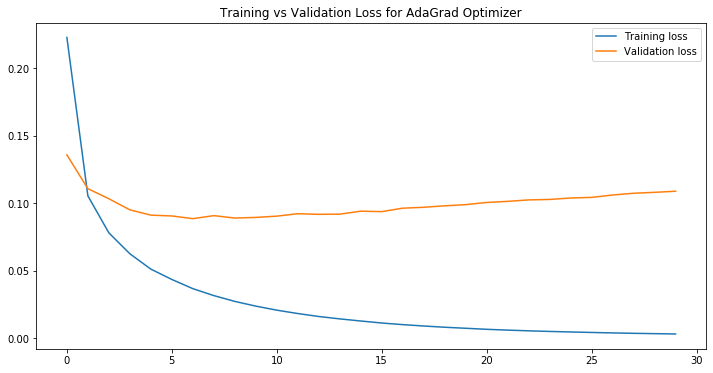

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs Validation Loss for AdaGrad Optimizer")
plt.show()

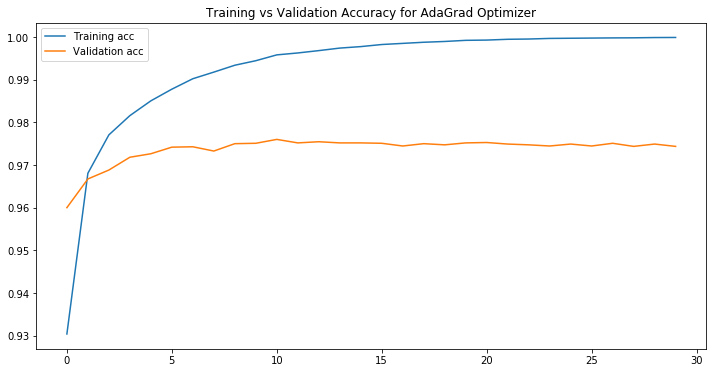

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.legend()
plt.title("Training vs Validation Accuracy for AdaGrad Optimizer")
plt.show()

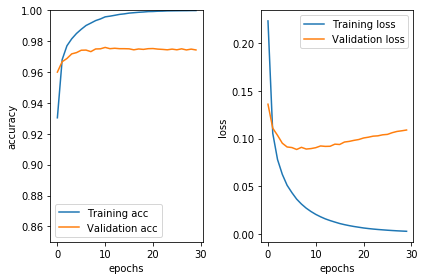

In [62]:
f, axs = plt.subplots(1,2)
axs[0].plot(history.history['accuracy'], label="Training acc")
axs[0].plot(history.history['val_accuracy'], label="Validation acc")
axs[0].legend()
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[0].set_ylim([0.85, 1])
axs[1].plot(history.history['loss'], label="Training loss")
axs[1].plot(history.history['val_loss'], label="Validation loss")
axs[1].legend()
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
#axs[1].set_ylim([0, 0.35])
plt.tight_layout()

In [63]:
# Select 25 random images from test images
idx = np.random.choice(X_test.shape[0], 25, replace=False)

# predict class for selected images
y_pred = model.predict_classes(X_test[idx])

# True class for selected images
y_true = y_test[idx].argmax(axis=1)

print('Test Accuracy of AdaGrad Optimizer = %.2f' % (100.0 * np.mean(y_pred == y_true)))

Test Accuracy of AdaGrad Optimizer = 92.00


In [64]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
print("Multi_layer_NN with AdaGrad Optimizer")
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[idx[i]].reshape(image_size, image_size), interpolation='spline16')
    pred_class = class_names[y_pred[i]]
    true_class = class_names[y_true[i]]
    ax.set_xlabel('Pred: {}\nTrue: {}'.format(pred_class, true_class), fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

Multi_layer_NN with AdaGrad Optimizer


### Batch size = 128,  Use RMSProp Optimizer

In [65]:
model.load_weights('model.h5')
optimizer = keras.optimizers.RMSprop()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
start = time.time()
history = model.fit(X_train[:num_train], y_train[:num_train], 
                    batch_size=128, 
                    epochs=30,
                    verbose=2,
                    validation_data=(X_train[num_train:], y_train[num_train:]),
                    shuffle=True)
end = time.time()
print("Time duration for RMSProp Optimizer:",end-start)

Train on 49000 samples, validate on 11000 samples
Epoch 1/30
 - 1s - loss: 0.2814 - accuracy: 0.9173 - val_loss: 0.1364 - val_accuracy: 0.9595
Epoch 2/30
 - 1s - loss: 0.1120 - accuracy: 0.9663 - val_loss: 0.1233 - val_accuracy: 0.9633
Epoch 3/30
 - 1s - loss: 0.0779 - accuracy: 0.9767 - val_loss: 0.1054 - val_accuracy: 0.9687
Epoch 4/30
 - 1s - loss: 0.0568 - accuracy: 0.9821 - val_loss: 0.0990 - val_accuracy: 0.9725
Epoch 5/30
 - 1s - loss: 0.0443 - accuracy: 0.9861 - val_loss: 0.1091 - val_accuracy: 0.9691
Epoch 6/30
 - 1s - loss: 0.0332 - accuracy: 0.9894 - val_loss: 0.1076 - val_accuracy: 0.9720
Epoch 7/30
 - 1s - loss: 0.0270 - accuracy: 0.9913 - val_loss: 0.1033 - val_accuracy: 0.9758
Epoch 8/30
 - 1s - loss: 0.0219 - accuracy: 0.9930 - val_loss: 0.1289 - val_accuracy: 0.9711
Epoch 9/30
 - 1s - loss: 0.0164 - accuracy: 0.9947 - val_loss: 0.1406 - val_accuracy: 0.9727
Epoch 10/30
 - 1s - loss: 0.0155 - accuracy: 0.9948 - val_loss: 0.1477 - val_accuracy: 0.9714
Epoch 11/30
 - 1s -

In [67]:
#model.save('Multi_layer_NN_Model_RMSProp.CA7')
#model = keras.models.load_model('Multi_layer_NN_Model_RMSProp.CA7')

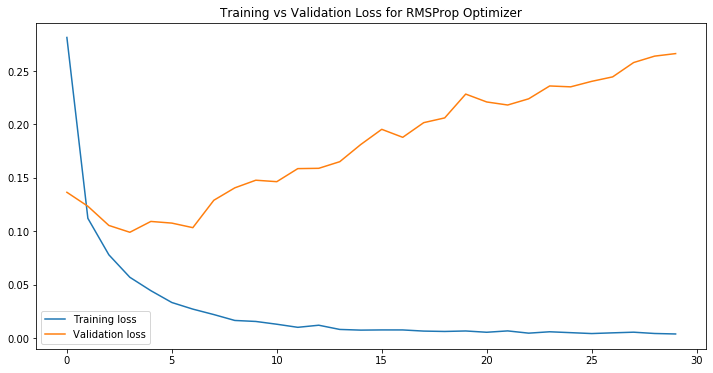

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs Validation Loss for RMSProp Optimizer")
plt.show()

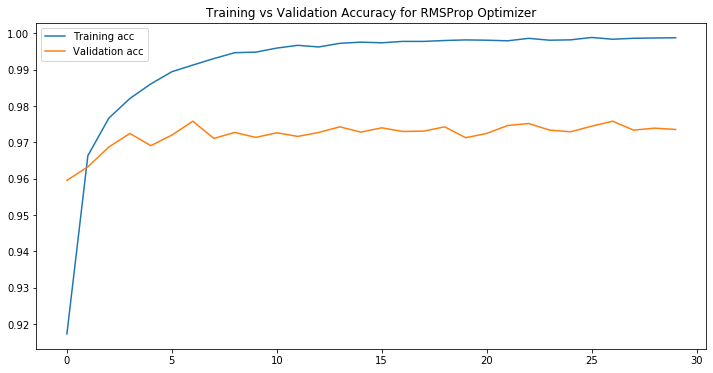

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.legend()
plt.title("Training vs Validation Accuracy for RMSProp Optimizer")
plt.show()

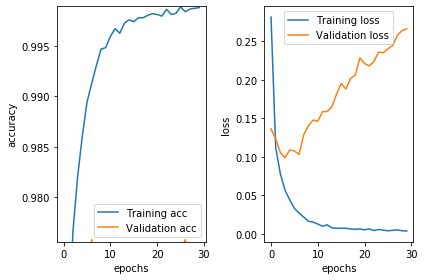

In [95]:
f, axs = plt.subplots(1,2)
axs[0].plot(history.history['accuracy'], label="Training acc")
axs[0].plot(history.history['val_accuracy'], label="Validation acc")
axs[0].legend()
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[0].set_ylim([0.9756, 0.9989])
axs[1].plot(history.history['loss'], label="Training loss")
axs[1].plot(history.history['val_loss'], label="Validation loss")
axs[1].legend()
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
#axs[1].set_ylim([0, 0.35])
plt.tight_layout()

In [71]:
# Select 25 random images from test images
idx = np.random.choice(X_test.shape[0], 25, replace=False)

# predict class for selected images
y_pred = model.predict_classes(X_test[idx])

# True class for selected images
y_true = y_test[idx].argmax(axis=1)

print('Test Accuracy of RMSProp Optimizer = %.2f' % (100.0 * np.mean(y_pred == y_true)))

Test Accuracy of RMSProp Optimizer = 96.00


Multi_layer_NN with RMSProp Optimizer


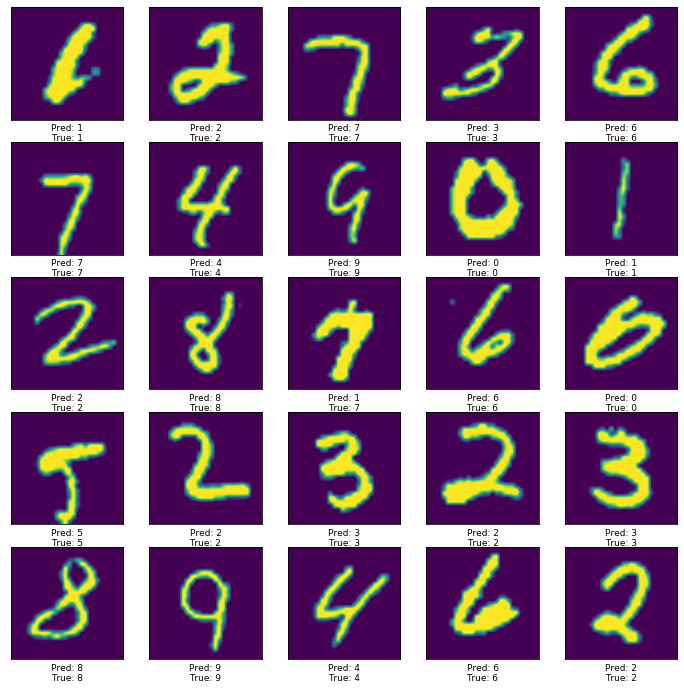

In [72]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
print("Multi_layer_NN with RMSProp Optimizer")
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[idx[i]].reshape(image_size, image_size), interpolation='spline16')
    pred_class = class_names[y_pred[i]]
    true_class = class_names[y_true[i]]
    ax.set_xlabel('Pred: {}\nTrue: {}'.format(pred_class, true_class), fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])